# 1. Imports and Setup

In [6]:
# Import necessary libraries and packages
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, roc_curve, ConfusionMatrixDisplay, 
    classification_report, cohen_kappa_score
)
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearnex import patch_sklearn
import joblib
import pickle

# Apply Intel extension to scikit-learn
patch_sklearn()

# Import GPU-accelerated libraries
from cuml.neighbors import KNeighborsClassifier as cuKNeighborsClassifier
from cuml.svm import SVC as cuSVC
import lightgbm as lgb
from catboost import CatBoostClassifier

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# 2. Feature Scaling and Preparation for Modeling

In [7]:
# Load and preprocess the dataset
file_path = 'combined_captured_data_MQTT_final.csv'  # Update this to the correct file path
data_MQTT_Filtred = pd.read_csv(file_path)

# Separate features and target
X = data_MQTT_Filtred.drop(columns=['target'])
y = data_MQTT_Filtred['target']

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Scaling the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

# Binarize labels for multiclass ROC-AUC
y_test_binarized = label_binarize(y_test, classes=np.unique(y))

# 4. Helper Functions for Model Evaluation and Visualization

In [8]:
# Initialize dictionaries to store results
roc_auc_scores = {}
best_params = {}
precision_recall_curves = {}
classification_reports = {}
cohen_kappa_scores = {}
training_times = {}
testing_times = {}

# Function to plot ROC curves for micro and macro average
def plot_roc_curve_micro_macro(y_true, y_pred_prob, model_name):
    fpr_micro, tpr_micro, _ = roc_curve(y_true.ravel(), y_pred_prob.ravel())
    roc_auc_micro = roc_auc_score(y_true, y_pred_prob, average='micro', multi_class='ovr')
    
    roc_auc_macro = roc_auc_score(y_true, y_pred_prob, average='macro', multi_class='ovr')
    
    plt.figure()
    plt.plot(fpr_micro, tpr_micro, label=f'{model_name} (Micro AUC = {roc_auc_micro:.2f}, Macro AUC = {roc_auc_macro:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc="lower right")
    plt.show()
    
    return roc_auc_micro, roc_auc_macro

# Function to plot learning curve
def plot_learning_curve(estimator, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=5, n_jobs=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    plt.figure()
    plt.plot(train_sizes, train_scores_mean, label='Training score')
    plt.plot(train_sizes, test_scores_mean, label='Validation score')
    plt.title(f'Learning Curve for {title}')
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    plt.legend(loc="best")
    plt.grid()
    plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(estimator, X_test, y_test, title):
    plt.figure()
    ConfusionMatrixDisplay.from_estimator(estimator, X_test, y_test, cmap='Blues')
    plt.title(f'Confusion Matrix for {title}')
    plt.show()

# Function to plot cross-validation scores
def plot_cross_val_scores(estimator, X, y, title):
    cv_scores = cross_val_score(estimator, X, y, cv=5)
    plt.figure()
    plt.bar(range(len(cv_scores)), cv_scores)
    plt.title(f'Cross-Validation Scores for {title}')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.grid()
    plt.show()

# Function to compute classification report and Cohen's Kappa score
def compute_classification_report(estimator, X_test, y_test):
    y_pred = estimator.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    kappa = cohen_kappa_score(y_test, y_pred)
    return report, kappa

# 5. Re-train the LightGBM model

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013689 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 720
[LightGBM] [Info] Number of data points in the train set: 443217, number of used features: 11
[LightGBM] [Info] Start training from score -1.791780
[LightGBM] [Info] Start training from score -1.789211
[LightGBM] [Info] Start training from score -1.793324
[LightGBM] [Info] Start training from score -1.791902
[LightGBM] [Info] Start training from score -1.791644
[LightGBM] [Info] Start training from score -1.792701


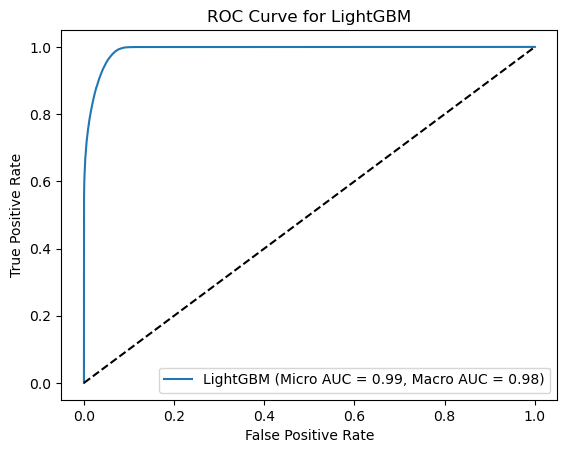

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002760 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 668
[LightGBM] [Info] Number of data points in the train set: 35457, number of used features: 11
[LightGBM] [Info] Start training from score -1.800171
[LightGBM] [Info] Start training from score -1.781406
[LightGBM] [Info] Start training from score -1.784257
[LightGBM] [Info] Start training from score -1.805647
[LightGBM] [Info] Start training from score -1.820513
[LightGBM] [Info] Start training from score -1.759704
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 699
[LightGBM] [Info] Number of data points in the train set: 115236,

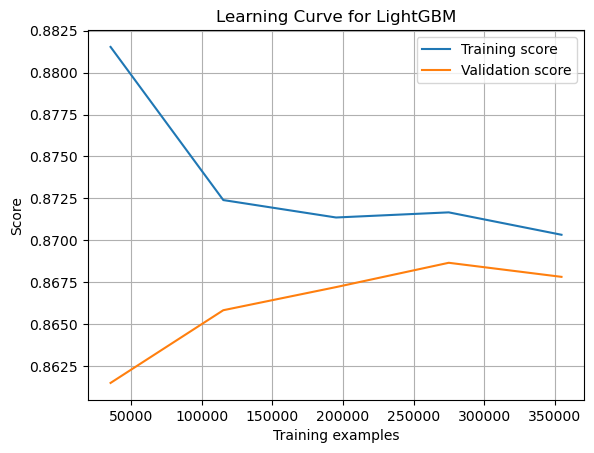

<Figure size 640x480 with 0 Axes>

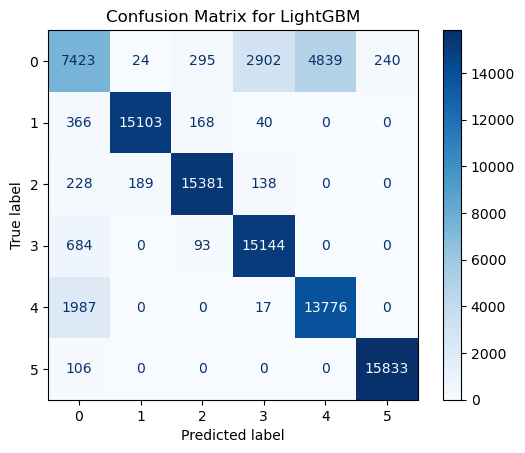

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 881
[LightGBM] [Info] Number of data points in the train set: 506534, number of used features: 11
[LightGBM] [Info] Start training from score -1.791763
[LightGBM] [Info] Start training from score -1.791763
[LightGBM] [Info] Start training from score -1.791752
[LightGBM] [Info] Start training from score -1.791763
[LightGBM] [Info] Start training from score -1.791752
[LightGBM] [Info] Start training from score -1.791763
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007019 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 506534

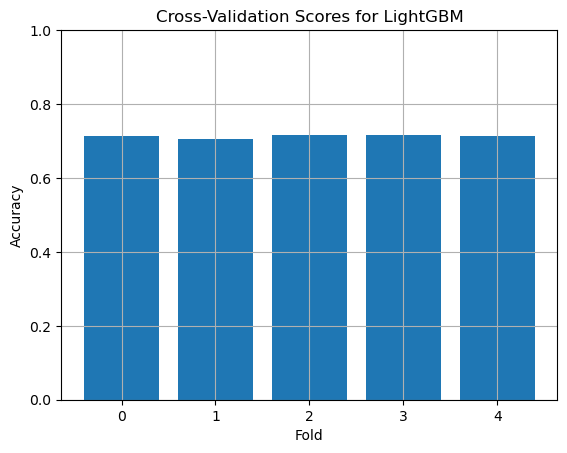

LightGBM model re-trained and saved as 'best_re-trained_lgb.pkl'.
      Model                                    Best Parameters  ROC AUC Micro  \
0  LightGBM  {'n_estimators': 100, 'learning_rate': 0.1, 'n...       0.991412   

   ROC AUC Macro  Cohen's Kappa  Accuracy  Precision    Recall  F1-Score  \
0       0.982241       0.844375  0.870325   0.865993  0.870325  0.863218   

   Training Time (s)  Testing Time (s)  
0           9.867418          0.636642  


TypeError: float() argument must be a string or a number, not 'dict'

<Figure size 1000x600 with 0 Axes>

In [9]:
lgb_model = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, num_leaves=31)
start_time = time.time()
lgb_model.fit(X_train, y_train)
training_times['LightGBM'] = time.time() - start_time

start_time = time.time()
y_pred_prob_lgb = lgb_model.predict_proba(X_test)
testing_times['LightGBM'] = time.time() - start_time

roc_auc_lgb_micro, roc_auc_lgb_macro = plot_roc_curve_micro_macro(y_test_binarized, y_pred_prob_lgb, "LightGBM")

# Store results
roc_auc_scores['LightGBM'] = (roc_auc_lgb_micro, roc_auc_lgb_macro)
best_params['LightGBM'] = {'n_estimators': 100, 'learning_rate': 0.1, 'num_leaves': 31}

plot_learning_curve(lgb_model, X_train, y_train, "LightGBM")
plot_confusion_matrix(lgb_model, X_test, y_test, "LightGBM")
plot_cross_val_scores(lgb_model, X, y, "LightGBM")

# Compute classification metrics
classification_reports['LightGBM'], cohen_kappa_scores['LightGBM'] = compute_classification_report(lgb_model, X_test, y_test)

# Save the model
# Save the re-trained model as 'best_re-trained_lgb.pkl'
with open('best_re-trained_lgb.pkl', 'wb') as f:
    pickle.dump(lgb_model, f)

print("LightGBM model re-trained and saved as 'best_re-trained_lgb.pkl'.")

# 14. Final Comparison Table
comparison_table = pd.DataFrame.from_dict({
    'Model': list(best_params.keys()),
    'Best Parameters': list(best_params.values()),
    'ROC AUC Micro': [scores[0] for scores in roc_auc_scores.values()],
    'ROC AUC Macro': [scores[1] for scores in roc_auc_scores.values()],
    'Cohen\'s Kappa': list(cohen_kappa_scores.values()),
    'Accuracy': [classification_reports[model]['accuracy'] for model in classification_reports],
    'Precision': [classification_reports[model]['weighted avg']['precision'] for model in classification_reports],
    'Recall': [classification_reports[model]['weighted avg']['recall'] for model in classification_reports],
    'F1-Score': [classification_reports[model]['weighted avg']['f1-score'] for model in classification_reports],
    'Training Time (s)': list(training_times.values()),
    'Testing Time (s)': list(testing_times.values())
})

# Display the comparison table
print(comparison_table)

# Optionally, visualize the comparison table as a plot
plt.figure(figsize=(10, 6))
sns.heatmap(comparison_table.set_index('Model').astype(float), annot=True, cmap='coolwarm')
plt.title('Model Comparison Table')
plt.show()

      Model                                    Best Parameters  ROC AUC Micro  \
0  LightGBM  {'n_estimators': 100, 'learning_rate': 0.1, 'n...       0.991412   

   ROC AUC Macro  Cohen's Kappa  Accuracy  Precision    Recall  F1-Score  \
0       0.982241       0.844375  0.870325   0.865993  0.870325  0.863218   

   Training Time (s)  Testing Time (s)  
0           9.867418          0.636642  


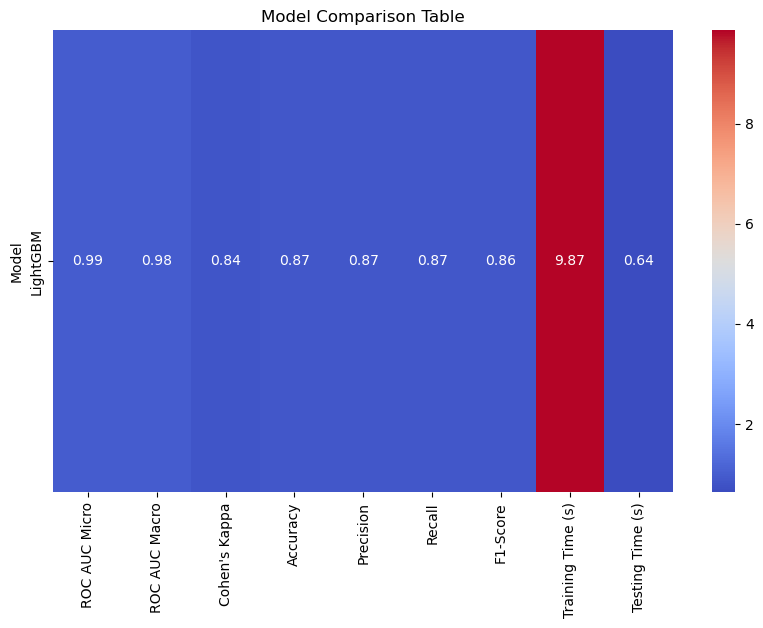

In [10]:
# Display the comparison table
print(comparison_table)

# Optionally, visualize the comparison table as a plot (excluding non-numeric columns)
numeric_columns = ['ROC AUC Micro', 'ROC AUC Macro', 'Cohen\'s Kappa', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Training Time (s)', 'Testing Time (s)']

plt.figure(figsize=(10, 6))
sns.heatmap(comparison_table[numeric_columns].set_index(comparison_table['Model']), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Model Comparison Table')
plt.show()
